# Tutorial for geometry.py

This notebook will introduce some of the most useful functionalities of the geometry.py class. The geometry.py module allows you to manipulate geometry file types of typical DFT codes. It has a focus on surface geometries. Beware this tutorial, among being exceedingly useful, contains attempts to be funny.

First we load the necessary dependecies:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dfttools import geometry

## The most useful stuff (IMO)
Let us start by reating a surface slab. First, we load a geometry and print the coordinates of the atoms in it. We are loading an AIMS-geometry, so we use the AimsGeometry class. There are also VaspGeometry and XYZGeometry classes. We use the <code>get_text</code> function to plrint the content of the geometry file.

In [3]:
geom = geometry.AimsGeometry('data/bulk_substrate.in')

print(geom.get_text())

lattice_vector     1.79800000     1.79800000     0.00000000
lattice_vector     1.79800000     0.00000000     1.79800000
lattice_vector     0.00000000     1.79800000     1.79800000
atom     0.00000000     0.00000000     0.00000000 Cu



Let us now visualise the geoemtry. The visualise function has **many** keyword parameters, all of which are very useful. But for a quick overview you don't need them. We will introduce some of them later on.

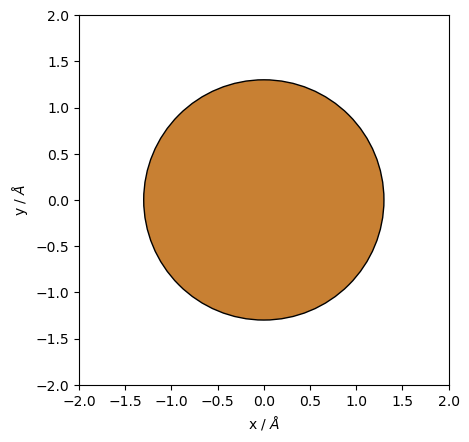

In [4]:
geom.visualise()

It turns out we loaded a single copper coloured atom. But is it really copper. Let's check.

In [5]:
geom.get_atomic_numbers_of_atoms()

array([29])

It is indeed. In fact, we loaded a bulk unit cell of copper, containing a single atom. Let's check if we have periodic boundary conditions.

In [6]:
geom.get_is_periodic()

True

It seems that our geometry is periodic. Let's make a lager patch of copper atoms using the periodica replica function.

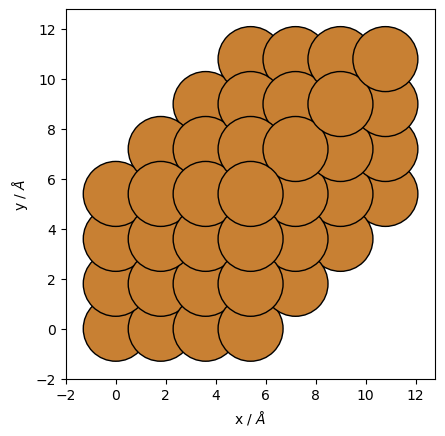

In [7]:
geom_rep = geom.get_periodic_replica((4,4,4))
geom_rep.visualise()

Great! We now have a patch of copper atoms. The <code>get_periodic_replica</code> function also replicates the lattice vectors and any other atom-wise property. Let's now check how many atoms we have.

In [8]:
len(geom_rep)

64

So we have 64 which is 4 x 4 x 4.

## Creating surface slabs

Let us now create a (111)-surface slab.

In [ ]:
geom_surf = geom.get_primitive_slab((1, 1, 1))
geom_surf.visualise()

You can also make weird surfaces. This will make the code run a bit longer, but it'll do it.

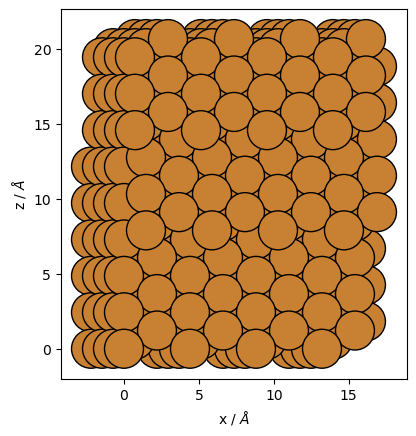

In [38]:
geom_surf_weired = geom.get_primitive_slab((5, 3, 1))
geom_surf_weired = geom_surf_weired.get_periodic_replica((4,4,1))
geom_surf_weired.visualise(axes=(0,2))

The visualise function can look at the structure from different angles using the <code>axes</code> keyword. It takes a tuple as input, where the two integers indicate the axes. We will look at the x and z-axes.

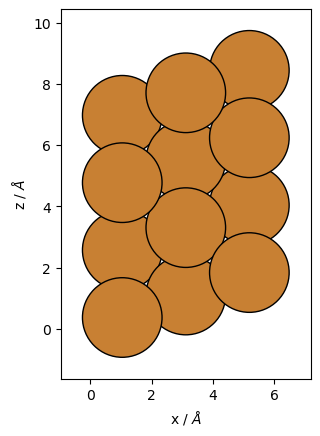

In [10]:
geom_surf.visualise(axes=[0,2])

Let's make this really a surface by adding a vacuum of 50 A.

In [11]:
geom_surf.set_vacuum_height(50)

print(geom_surf.get_text())

lattice_vector     6.22845470     0.00000000     0.00000000
lattice_vector     0.00000000     2.54275599     0.00000000
lattice_vector     0.00000000     -0.00000000     58.07433469
atom     1.03807578     0.63568900     4.77119777 Cu
atom     1.03807578     1.90706699     6.97328905 Cu
atom     5.19037892     0.63568900     6.23925862 Cu
atom     3.11422735     1.90706699     5.50522820 Cu
atom     3.11422735     0.63568900     7.70731948 Cu
atom     3.11422735     1.90706699     1.10104564 Cu
atom     1.03807578     0.63568900     0.36701521 Cu
atom     5.19037892     1.90706699     8.44134990 Cu
atom     1.03807578     1.90706699     2.56910649 Cu
atom     5.19037892     0.63568900     1.83507607 Cu
atom     5.19037892     1.90706699     4.03716734 Cu
atom     3.11422735     0.63568900     3.30313692 Cu



Now we have a surface slab, containing three layers. Let us replicate it with the <code>get_periodic_replica</code> function to get a surface unit cell. Note that we replicate 8 times in x, 8 times in y and only 1 time in z direction. I.e. we just keep our 3 layers in z-direction.

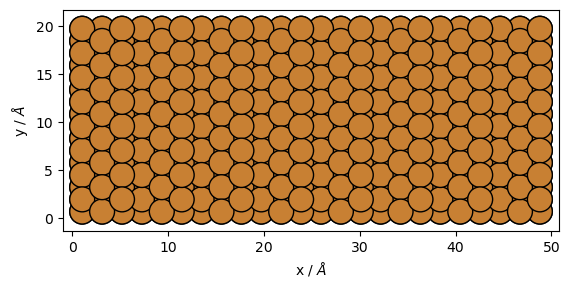

In [12]:
geom_surf_rep = geom_surf.get_periodic_replica((8,8,1))
geom_surf_rep.visualise()

Alternatively we can use the <code>get_slab</code> function. This also allows us to define a specific number of layers.

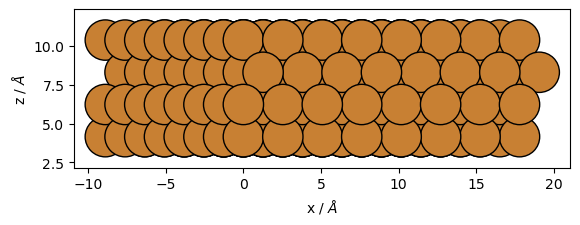

In [13]:
geom_surf_rep = geom.get_slab(4, surface=(1, 1, 1), surface_replica=(8, 8))

geom_surf_rep.visualise(axes=(0,2))

## Adding a molecule

We will now add a molecule to our slab. We will first load and visulaise it.

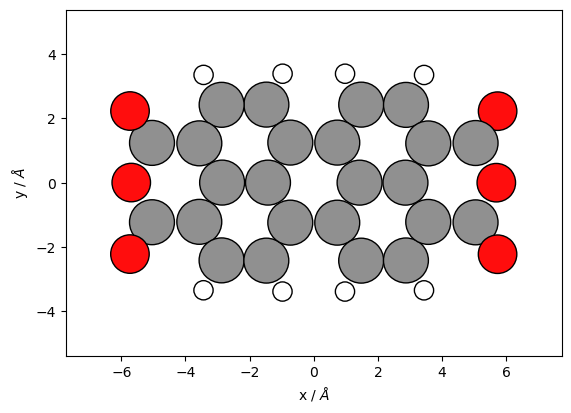

In [14]:
mol = geometry.AimsGeometry('data/molecule.in')
mol.visualise()

Ok, that's nice. But it is too horizontal. Let's rotate the molecule around the z-axis using the <code>rotate_coords_around_axis</code> function. By default, it will rotate around the z-axis, but you can give it any axis you like. The rotate function manipulates in place. Function that return a new geometry start with <code>get_</code>.

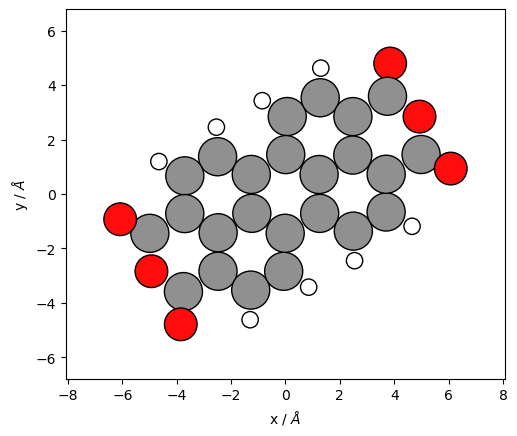

In [15]:
mol.rotate_coords_around_axis(30)
mol.visualise()

That's a better angle. Let's add it to the surface slab. First, we grab the highest z-coordinate of the substrate and the lowest z-coordinate of the molecule. There we have to get manually from <code>geom.coords</code>.

In [16]:
z_offset = np.max(geom_surf_rep.coords[:,2]) - np.min(mol.coords[:,2])

Let's place our molecule 3 Angstrom above the slab. The units geometry.py works in are Angstrom. So we add 3 to <code>z_offset</code> and move our molecule in z-direction.

In [17]:
z_move = np.array([0, 0, z_offset + 3])
mol.move_all_atoms(z_move)

Now we just add <code>mol</code> to <code>geom_surf_rep</code>.

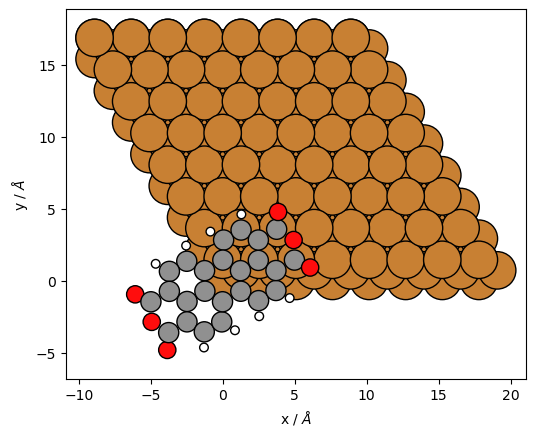

In [18]:
geom_mol = geom_surf_rep + mol
geom_mol.visualise()

## Removing atoms

Ok ... well ... it sticks out. I don't like it. So let's remove the molecule and start over again. We can remove molecules with the <code>remove_adsorbates</code> function. You can give it the <code>primitive_substrate</code>, but you don't have to. If you don't the code will assume that your has any of these atomic numbers $Z > 18 \vee Z \in \{3, 4, 11, 12, 13, 14\}$. This is a bit risky so the code will produce a warning. We'll just ignore it.

/home/lukas/Source/dfttools/dfttools/geometry.py:2552: UserWarning: Geometry.getIndicesOfAdsorbates: Substrate is not explicitly defined. Using fallback solution of counting all metal atoms as substrate.
  warnings.warn(


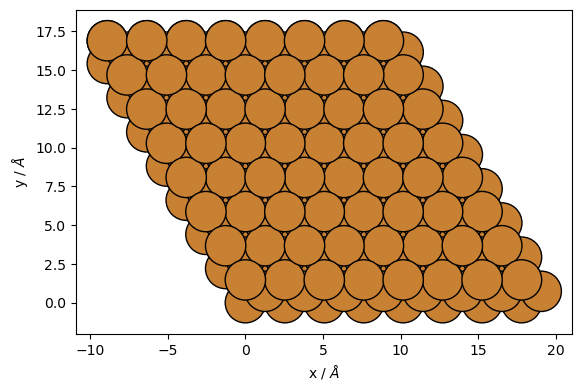

In [19]:
geom_mol.remove_adsorbates()
geom_mol.visualise()

## Manipulating a geometry

Let's now move our molecule. But first we will do some prep-work. First we will center our geometry.

In [20]:
mol.center_coordinates()

array([ 4.91550000e-05, -2.41797632e-04,  1.33807578e+01])

Then we will align our molecule with the Cartesian axes again.

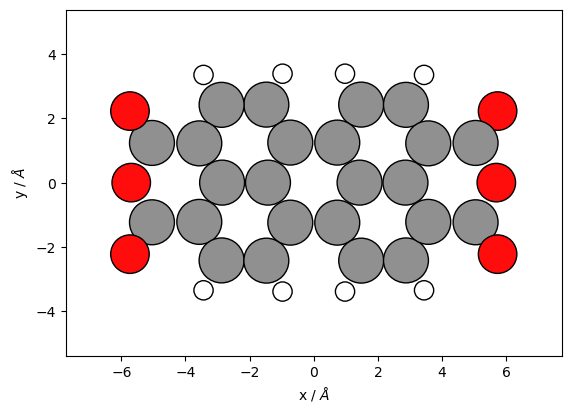

In [21]:
mol.align_main_axis_along_xyz()
mol.visualise()

Now that we have our molecule back to normal, we are ready to move it again. We could move it with <code>move_all_atoms</code> if we know the distances in Cartesian coordinates. We can also move the molecule by fractional coordinates. To do this we will use <code>move_all_atoms_by_fractional_coords</code> and use the primitive substrate lattice vectors of <code>geom_surf</code>.

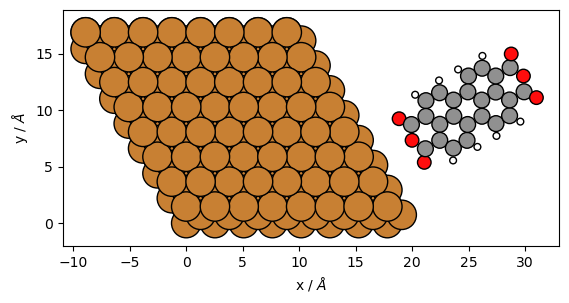

In [22]:
# Rotate the molecule
mol.rotate_coords_around_axis(30)

# Move molecule in z-direction in Cartesian coordinates
mol.move_all_atoms(z_move)

# Get primitive substrate lattice vectors
lattice = geom_surf.lattice_vectors

# Move molecule in fractinal coordinates
mol.move_all_atoms_by_fractional_coords((4,4,0), lattice_vectors=lattice)

# Add molecule to slab
geom_mol += mol

# Visualise
geom_mol.visualise()

## Saving geomeries

That's how it's supposed to be. Now that we have a nice geometry we want to save it. This is easy:

In [23]:
geom_mol.save_to_file('temp/whatever_name_you_facy.in')

But what if we want to use VASP to calculate it? Then we'll just convert our geometry. Then we could save it. But for the purpose of this tutorial, we will just look at the text in the geomertry here, using the <code>get_text</code> function.

In [24]:
geom_vasp = geom_mol.get_instance_of_other_type('vasp')
print(geom_vasp.get_text())

POSCAR file written by Geometry.py
1
20.34204788     0.00000000     0.00000000
-10.17102394     17.61673023     0.00000000
0.00000000     -0.00000000     12.45690941
C Cu H O
24 256 8 6
Selective dynamics
Cartesian
 22.41821640     11.53743404     13.38075784
 21.21366245     10.83408806     13.38075784
 21.21244324     9.44660625     13.38075784
 22.43937155     8.74231776     13.38075784
 22.43570499     7.32758311     13.38075784
 23.63788653     6.63488462     13.38075784
 24.84943482     7.32630684     13.38075784
 24.90415655     8.72454997     13.38075784
 23.67772742     9.45717785     13.38075784
 23.65641096     10.88555309     13.38075784
 24.92363738     11.61722834     13.38075784
 26.15003980     10.88465498     13.38075784
 26.17141574     9.45623287     13.38075784
 27.40970826     8.80452372     13.38075784
 28.61419904     9.50805807     13.38075784
 28.61531707     10.89553962     13.38075784
 27.38829735     11.59967949     13.38075784
 27.39176694     13.01440305  

## But what if you're like Nils?

If you have specific requirements regarding colours, you can create a vector containing colours. This is what the argument <code>color_list</code> is for.

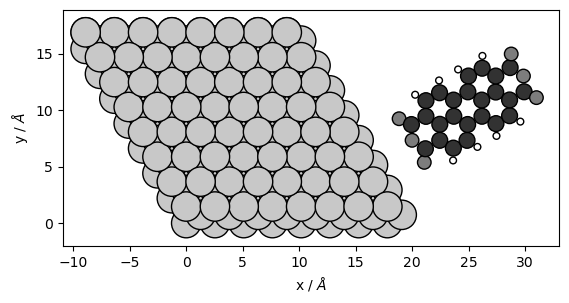

In [25]:
H_color = np.array([255, 255, 255])/255
C_color = np.array([50, 50, 50])/255
O_color = np.array([125, 125, 125])/255
Cu_color = np.array([200, 200, 200])/255

color_list = []
for species in geom_mol.species:
    if species == 'H':
        color_list.append(H_color)
    if species == 'C':
        color_list.append(C_color)
    if species == 'O':
        color_list.append(O_color)
    if species == 'Cu':
        color_list.append(Cu_color)

geom_mol.visualise(color_list=color_list)

Perfect! In fact <code>color_list</code> and the similarish argument <code>value_list</code> can be used to visualise atom-wise properties of your structure. Let's visualise the height of each atom in our geometry using the <code>value_list</code> argument.

Maxvalue for colormap not specified, 
setting it automatically to:  13.380757840029482


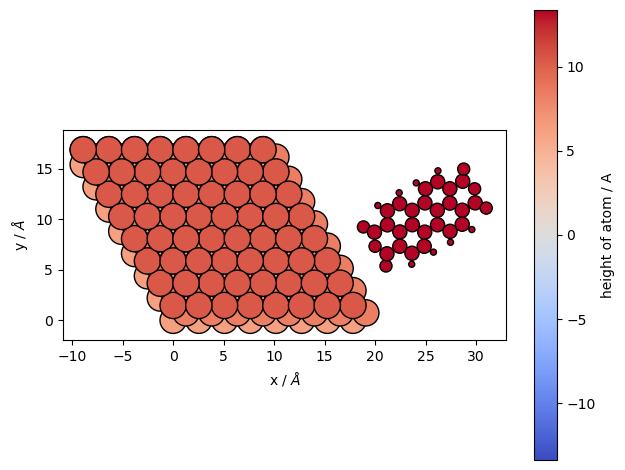

In [26]:
height = geom_mol.coords[:,2]

geom_mol.visualise(value_list=height, cbar_label='height of atom / A')

plt.tight_layout()

The <code>value_list</code> argument can be incredibly useful. You can also select a custom colourmap and set the limits on the colour range.

## Constraints and other atom-wise attributes

Constraints are vitally important for geometry optimisations, MD simulation, and much more. External forces, multiple charges, calculate friction, and other attributes can also be vitally important. Not all of these properties can be used in all codes, and geometry's focus is on FHI aims. Here, we will briefly look at relaxation constraints.

The <code>set_constraints</code> function allows you to apply constraints to specific atoms. It takes two arguments: the indices of the atoms to constrain and the directions in which to restrict relaxation. First, we’ll obtain the atom indices in the lowest layer of our slab and then apply constraints. For this, we use the <code>get_atom_layers_indices</code> function, which returns a <code>dict</code>. In this dictionary, the keys represent atom species, while each value is a nested dictionary with layer heights as keys and lists of atom indices at each height as values.

In [27]:
layers = geom_mol.get_atom_layers_indices()

print(layers)

{'Cu': {4.152303136011789: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252], 10.38075784002947: [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253], 6.2284547040176825: [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254], 8.304606272023577: [3, 7, 11, 15, 19, 23, 27, 31, 3

We use a simple for loop to get the lowest lying layer.

In [28]:
# Get layers of Cu
layers_Cu = layers['Cu']

# Find height of lowest layer
height_min = np.inf

for height, atom_indices in layers_Cu.items():
    if height_min > height:
        height_min = height

# Get indices of atoms in lowest layer
constrain_indices = layers_Cu[height_min]

print(constrain_indices)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252]


In [29]:
geom_mol.set_constraints(constrain_indices, constrain_dim_flags=[True, True, True])

print(geom_mol.get_text())

lattice_vector     20.34204788     0.00000000     0.00000000
lattice_vector     -10.17102394     17.61673023     0.00000000
lattice_vector     0.00000000     -0.00000000     12.45690941
atom     -0.00000000     1.46806085     4.15230314 Cu
constrain_relaxation .true.
atom     -0.00000000     1.46806085     10.38075784 Cu
atom     0.00000000     -0.00000000     6.22845470 Cu
atom     1.27137799     0.73403043     8.30460627 Cu
atom     -1.27137799     3.67015213     4.15230314 Cu
constrain_relaxation .true.
atom     -1.27137799     3.67015213     10.38075784 Cu
atom     -1.27137799     2.20209128     6.22845470 Cu
atom     0.00000000     2.93612171     8.30460627 Cu
atom     -2.54275599     5.87224341     4.15230314 Cu
constrain_relaxation .true.
atom     -2.54275599     5.87224341     10.38075784 Cu
atom     -2.54275599     4.40418256     6.22845470 Cu
atom     -1.27137799     5.13821298     8.30460627 Cu
atom     -3.81413398     8.07433469     4.15230314 Cu
constrain_relaxation .true.

Cool! We have constrained the Cu atoms lying at a height of 0 A. But what if we wanted to only constrain the x and y directions? Let's first free all constraints and then set them again only for x and y.

In [30]:
geom_surf_rep.free_all_constraints()

geom_surf_rep.set_constraints(constrain_indices, constrain_dim_flags=[True, True, False])

print(geom_surf_rep.get_text())

lattice_vector     20.34204788     0.00000000     0.00000000
lattice_vector     -10.17102394     17.61673023     0.00000000
lattice_vector     0.00000000     -0.00000000     12.45690941
atom     -0.00000000     1.46806085     4.15230314 Cu
constrain_relaxation x
constrain_relaxation y
atom     -0.00000000     1.46806085     10.38075784 Cu
atom     0.00000000     -0.00000000     6.22845470 Cu
atom     1.27137799     0.73403043     8.30460627 Cu
atom     -1.27137799     3.67015213     4.15230314 Cu
constrain_relaxation x
constrain_relaxation y
atom     -1.27137799     3.67015213     10.38075784 Cu
atom     -1.27137799     2.20209128     6.22845470 Cu
atom     0.00000000     2.93612171     8.30460627 Cu
atom     -2.54275599     5.87224341     4.15230314 Cu
constrain_relaxation x
constrain_relaxation y
atom     -2.54275599     5.87224341     10.38075784 Cu
atom     -2.54275599     4.40418256     6.22845470 Cu
atom     -1.27137799     5.13821298     8.30460627 Cu
atom     -3.81413398     8.

## Symmetries

Geometries often have symmetries and these are very important. Nils tells me that ***everything*** can be derived from symmetries. So lets see what symmetries our strutures have. (Currently symmetries are only implemented for periodic structures. Feel free of implement symmetries for clusters.)

We start with the primitive bulk.

In [31]:
rotations, translations = geom.get_symmetries()

print('number of symmetries', len(rotations))

for R in rotations:
    print(R)

number of symmetries 48
[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[[ 0  0 -1]
 [-1  0  0]
 [ 1  1  1]]
[[ 0  0  1]
 [ 1  0  0]
 [-1 -1 -1]]
[[-1 -1 -1]
 [ 0  0  1]
 [ 0  1  0]]
[[ 1  1  1]
 [ 0  0 -1]
 [ 0 -1  0]]
[[ 0 -1  0]
 [ 1  1  1]
 [-1  0  0]]
[[ 0  1  0]
 [-1 -1 -1]
 [ 1  0  0]]
[[ 0  1  0]
 [ 1  0  0]
 [-1 -1 -1]]
[[ 0 -1  0]
 [-1  0  0]
 [ 1  1  1]]
[[-1  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]
[[1 0 0]
 [0 0 1]
 [0 1 0]]
[[ 0  0  1]
 [-1 -1 -1]
 [ 1  0  0]]
[[ 0  0 -1]
 [ 1  1  1]
 [-1  0  0]]
[[ 1  1  1]
 [ 0 -1  0]
 [ 0  0 -1]]
[[-1 -1 -1]
 [ 0  1  0]
 [ 0  0  1]]
[[0 1 0]
 [0 0 1]
 [1 0 0]]
[[ 0 -1  0]
 [ 0  0 -1]
 [-1  0  0]]
[[-1  0  0]
 [ 1  1  1]
 [ 0  0 -1]]
[[ 1  0  0]
 [-1 -1 -1]
 [ 0  0  1]]
[[ 0  0  1]
 [ 0  1  0]
 [-1 -1 -1]]
[[ 0  0 -1]
 [ 0 -1  0]
 [ 1  1  1]]
[[ 1  1  1]
 [-1  0  0]
 [ 0 -1  0]]
[[-1 -1 -1]
 [ 1  0  0]
 [ 0  1  0]]
[[ 1  0  0]
 [-1 -1 -1]
 [ 0  1  0]]
[[-1  0  0]
 [ 1  1  1]
 [ 0 -1  0]]
[[ 0  0 -1]
 [ 0 -1  0]
 [-1  0  0]]
[[0 

The primitive bulk has 48 symmetry operations (including improper rotations), as we'd expect for an FCC crystal structure like that of Cu.

Now we'll prepare a primitve substrate unit cell with 4 layers and determine it's symmetries.

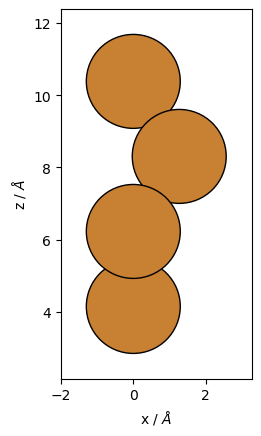

In [32]:
geom_surf = geom.get_slab(4, surface=(1, 1, 1), surface_replica=(1, 1))
geom_surf.set_vacuum_height(50)
geom_surf.visualise(axes=(0,2))

In [33]:
rotations, translations = geom_surf.get_symmetries()

print('number of symmetries', len(rotations))

for R in rotations:
    print(R)

number of symmetries 12
[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[[ 0 -1  0]
 [ 1 -1  0]
 [ 0  0  1]]
[[ 0  1  0]
 [-1  1  0]
 [ 0  0 -1]]
[[-1  1  0]
 [-1  0  0]
 [ 0  0  1]]
[[ 1 -1  0]
 [ 1  0  0]
 [ 0  0 -1]]
[[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]]
[[ 0 -1  0]
 [-1  0  0]
 [ 0  0  1]]
[[ 1 -1  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[[-1  1  0]
 [ 0  1  0]
 [ 0  0  1]]
[[-1  0  0]
 [-1  1  0]
 [ 0  0 -1]]
[[ 1  0  0]
 [ 1 -1  0]
 [ 0  0  1]]


The primitive (111) surface of an FCC crystal structure, such as that of copper (Cu), possesses 12 symmetry operations, including the mirror reflection across the z-axis. If you wish to exclude the symmetries resulting from the mirror reflection along the z-axis, you can set the argument <code>remove_reflection_in_z=True</code>.

In [34]:
rotations, translations = geom_surf.get_symmetries(remove_refelction_in_z=True)

print('number of symmetries', len(rotations))

for R in rotations:
    print(R)

number of symmetries 6
[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[ 0 -1  0]
 [ 1 -1  0]
 [ 0  0  1]]
[[-1  1  0]
 [-1  0  0]
 [ 0  0  1]]
[[ 0 -1  0]
 [-1  0  0]
 [ 0  0  1]]
[[-1  1  0]
 [ 0  1  0]
 [ 0  0  1]]
[[ 1  0  0]
 [ 1 -1  0]
 [ 0  0  1]]


Now we get the 6 symmetry operation for the 111-surface we know and love.